# Проект: вариант 1

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
Предложите метрики для оценки результатов последнего прошедшего тематического события в игре. 

## Задание 1

Retention – один из самых важных показателей в компании. Задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

### Загрузка данных из файлов в датафреймы и изучение общей информации

Импортируем все необходимые библиотеки.

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats
from scipy.stats import chi2_contingency, chi2 
from scipy.stats import norm
from tqdm.auto import tqdm


Данные о времени регистрации.

Откроем файл с данными и выведем на экран первые 5 строчек датафрейма reg_data.

In [2]:
reg_data = pd.read_csv('problem1-reg_data.csv',\
                       sep=';')

In [3]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


Посмотрим количество строк и столбцов в датафрейме reg_data. А также какой тип данных в каждом столбце.

In [4]:
reg_data.shape

(1000000, 2)

In [5]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


Проверим наличие пропусков в столбцах.

In [6]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

Данные о времени захода пользователей в игру.

Откроем файл с данными и выведем на экран первые 5 строчек датафрейма auth_data.

In [7]:
auth_data = pd.read_csv('problem1-auth_data.csv',\
                        sep=';')

In [8]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


Посмотрим количество строк и столбцов в датафрейме auth_data. А также какой тип данных в каждом столбце.

In [9]:
auth_data.shape

(9601013, 2)

In [10]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


Проверим наличие пропусков в столбцах.

In [11]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

### Основная часть

Объединим датафремы по столбцу uid, чтобы все даты заходов в игру попали в новый датафрейм.

In [12]:
full_data = auth_data.merge(reg_data, how='left', on='uid')

In [13]:
full_data.head()

,auth_ts,uid,reg_ts
0,911382223,1,911382223
1,932683089,2,932683089
2,932921206,2,932683089
3,933393015,2,932683089
4,933875379,2,932683089


In [14]:
full_data.shape

(9601013, 3)

Создадим два новых столбца в датафрейме full_data, в которых преобразуем время из секунд в объект datetime.

In [15]:
full_data['reg_time'] = pd.to_datetime(full_data['reg_ts'], unit='s')
full_data['auth_time'] = pd.to_datetime(full_data['auth_ts'], unit='s')

In [16]:
full_data.head()

,auth_ts,uid,reg_ts,reg_time,auth_time
0,911382223,1,911382223,1998-11-18 09:43:43,1998-11-18 09:43:43
1,932683089,2,932683089,1999-07-22 22:38:09,1999-07-22 22:38:09
2,932921206,2,932683089,1999-07-22 22:38:09,1999-07-25 16:46:46
3,933393015,2,932683089,1999-07-22 22:38:09,1999-07-31 03:50:15
4,933875379,2,932683089,1999-07-22 22:38:09,1999-08-05 17:49:39


Проверим тип данных.

In [17]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9601013 entries, 0 to 9601012
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   auth_ts    int64         
 1   uid        int64         
 2   reg_ts     int64         
 3   reg_time   datetime64[ns]
 4   auth_time  datetime64[ns]
dtypes: datetime64[ns](2), int64(3)
memory usage: 439.5 MB


Посмотрим на первую и последнюю дату регистрации пользователей и первую и последнюю дату захода пользователей в игру.

In [18]:
reg_time_min = full_data['reg_time'].min()
reg_time_max = full_data['reg_time'].max()
auth_time_min = full_data['auth_time'].min()
auth_time_max = full_data['auth_time'].max()

print('Первая дата регистрации:', reg_time_min)
print('Последняя дата регистрации:', reg_time_max)
print('Первая дата захода в игру:', auth_time_min)
print('Последняя дата захода в игру:', auth_time_max)

Первая дата регистрации: 1998-11-18 09:43:43
Последняя дата регистрации: 2020-09-23 15:17:24
Первая дата захода в игру: 1998-11-18 09:43:43
Последняя дата захода в игру: 2020-09-23 15:17:24


Оставим только дату без времени, при этом будем помнить, что тип данных  в новых столбцах у нас будет object.

In [19]:
full_data['reg_date'] = full_data['reg_time'].dt.date
full_data['auth_date'] = full_data['auth_time'].dt.date

In [20]:
full_data.head()

,auth_ts,uid,reg_ts,reg_time,auth_time,reg_date,auth_date
0,911382223,1,911382223,1998-11-18 09:43:43,1998-11-18 09:43:43,1998-11-18,1998-11-18
1,932683089,2,932683089,1999-07-22 22:38:09,1999-07-22 22:38:09,1999-07-22,1999-07-22
2,932921206,2,932683089,1999-07-22 22:38:09,1999-07-25 16:46:46,1999-07-22,1999-07-25
3,933393015,2,932683089,1999-07-22 22:38:09,1999-07-31 03:50:15,1999-07-22,1999-07-31
4,933875379,2,932683089,1999-07-22 22:38:09,1999-08-05 17:49:39,1999-07-22,1999-08-05


Добавим столбец с годом, чтобы построить график.

In [21]:
full_data['year'] = full_data['auth_time'].dt.strftime('%Y')
full_data.head()

,auth_ts,uid,reg_ts,reg_time,auth_time,reg_date,auth_date,year
0,911382223,1,911382223,1998-11-18 09:43:43,1998-11-18 09:43:43,1998-11-18,1998-11-18,1998
1,932683089,2,932683089,1999-07-22 22:38:09,1999-07-22 22:38:09,1999-07-22,1999-07-22,1999
2,932921206,2,932683089,1999-07-22 22:38:09,1999-07-25 16:46:46,1999-07-22,1999-07-25,1999
3,933393015,2,932683089,1999-07-22 22:38:09,1999-07-31 03:50:15,1999-07-22,1999-07-31,1999
4,933875379,2,932683089,1999-07-22 22:38:09,1999-08-05 17:49:39,1999-07-22,1999-08-05,1999


Посмотрим распределение пользователей во времени.

In [22]:
count_users_reg_by_date = full_data.groupby('year', as_index=False).agg({'uid' : 'nunique'}).sort_values('year')

In [23]:
count_users_reg_by_date

,year,uid
0,1998,1
1,1999,1
2,2000,5
3,2001,7
4,2002,11
5,2003,21
6,2004,37
7,2005,66
8,2006,122
9,2007,227


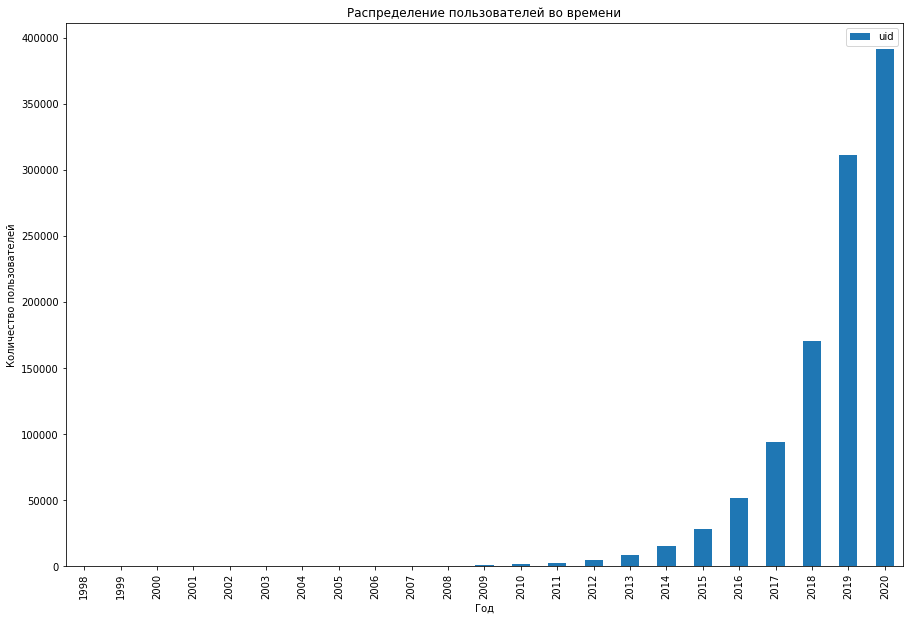

In [24]:
count_users_reg_by_date.plot(figsize=(15, 10),
kind='bar', 
x='year',
y='uid')
plt.title('Распределение пользователей во времени')
plt.xlabel('Год')
plt.ylabel('Количество пользователей');

С начала первой активности 1998 до 2017 года количество пользователей очень маленькое, так что предлагаю сразу исключить их и рассматривать период с 2018 по 2020.

Прежде чем создавать функцию, пропишем каждый шаг отдельно, чтобы исключить ошибки.

Зададим временной интервал. Возьмем предпоследний месяц, за который у нас есть данные.

In [25]:
start_date = datetime.date(2020, 8, 1)
end_date = datetime.date(2020, 8, 31)

Добавим столбец с количеством дней, прошедших после регистрации.

In [26]:
full_data['period'] = ((full_data.auth_date - full_data.reg_date) / np.timedelta64(1, 'D')).astype(int)

In [27]:
full_data.head()

,auth_ts,uid,reg_ts,reg_time,auth_time,reg_date,auth_date,year,period
0,911382223,1,911382223,1998-11-18 09:43:43,1998-11-18 09:43:43,1998-11-18,1998-11-18,1998,0
1,932683089,2,932683089,1999-07-22 22:38:09,1999-07-22 22:38:09,1999-07-22,1999-07-22,1999,0
2,932921206,2,932683089,1999-07-22 22:38:09,1999-07-25 16:46:46,1999-07-22,1999-07-25,1999,3
3,933393015,2,932683089,1999-07-22 22:38:09,1999-07-31 03:50:15,1999-07-22,1999-07-31,1999,9
4,933875379,2,932683089,1999-07-22 22:38:09,1999-08-05 17:49:39,1999-07-22,1999-08-05,1999,14


Возьмем данные за заданый временной интервал.

In [28]:
filtr_date = full_data.query('reg_date >= @start_date and auth_date <= @end_date')

Вычислим размеры когорт по дате регистрации.

In [29]:
cohorts = filtr_date.groupby(['reg_date', 'period'], as_index=False).agg({'uid': 'nunique'})\
                    .pivot(index='reg_date', columns='period', values='uid')
cohorts.head()

period,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
reg_date,,,,,,,,,,,,,,,,,,,,,
2020-08-01,1507.0,29.0,67.0,65.0,84.0,89.0,115.0,96.0,68.0,96.0,...,51.0,61.0,57.0,63.0,62.0,38.0,47.0,48.0,46.0,41.0
2020-08-02,1509.0,39.0,61.0,66.0,78.0,98.0,100.0,91.0,68.0,80.0,...,69.0,58.0,59.0,60.0,49.0,51.0,45.0,51.0,50.0,NaN
2020-08-03,1512.0,26.0,65.0,61.0,84.0,93.0,114.0,80.0,75.0,74.0,...,62.0,66.0,45.0,59.0,48.0,66.0,51.0,49.0,NaN,NaN
2020-08-04,1514.0,31.0,54.0,71.0,79.0,80.0,98.0,78.0,67.0,71.0,...,60.0,46.0,67.0,44.0,48.0,45.0,48.0,NaN,NaN,NaN
2020-08-05,1517.0,39.0,53.0,61.0,87.0,77.0,118.0,93.0,64.0,72.0,...,51.0,50.0,50.0,57.0,45.0,54.0,NaN,NaN,NaN,NaN


Посчитаем retention.

In [30]:
result_grouped = cohorts.div(cohorts[0], axis=0)
result_grouped.head()

period,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
reg_date,,,,,,,,,,,,,,,,,,,,,
2020-08-01,1.0,0.019244,0.044459,0.043132,0.055740,0.059058,0.076311,0.063703,0.045123,0.063703,...,0.033842,0.040478,0.037823,0.041805,0.041141,0.025216,0.031188,0.031851,0.030524,0.027206
2020-08-02,1.0,0.025845,0.040424,0.043738,0.051690,0.064944,0.066269,0.060305,0.045063,0.053015,...,0.045726,0.038436,0.039099,0.039761,0.032472,0.033797,0.029821,0.033797,0.033135,NaN
2020-08-03,1.0,0.017196,0.042989,0.040344,0.055556,0.061508,0.075397,0.052910,0.049603,0.048942,...,0.041005,0.043651,0.029762,0.039021,0.031746,0.043651,0.033730,0.032407,NaN,NaN
2020-08-04,1.0,0.020476,0.035667,0.046896,0.052180,0.052840,0.064729,0.051519,0.044254,0.046896,...,0.039630,0.030383,0.044254,0.029062,0.031704,0.029723,0.031704,NaN,NaN,NaN
2020-08-05,1.0,0.025709,0.034937,0.040211,0.057350,0.050758,0.077785,0.061305,0.042189,0.047462,...,0.033619,0.032960,0.032960,0.037574,0.029664,0.035597,NaN,NaN,NaN,NaN


Убираем нулевой день.

In [31]:
result_grouped = result_grouped.drop(columns=[0])

Построим тепловую карту.

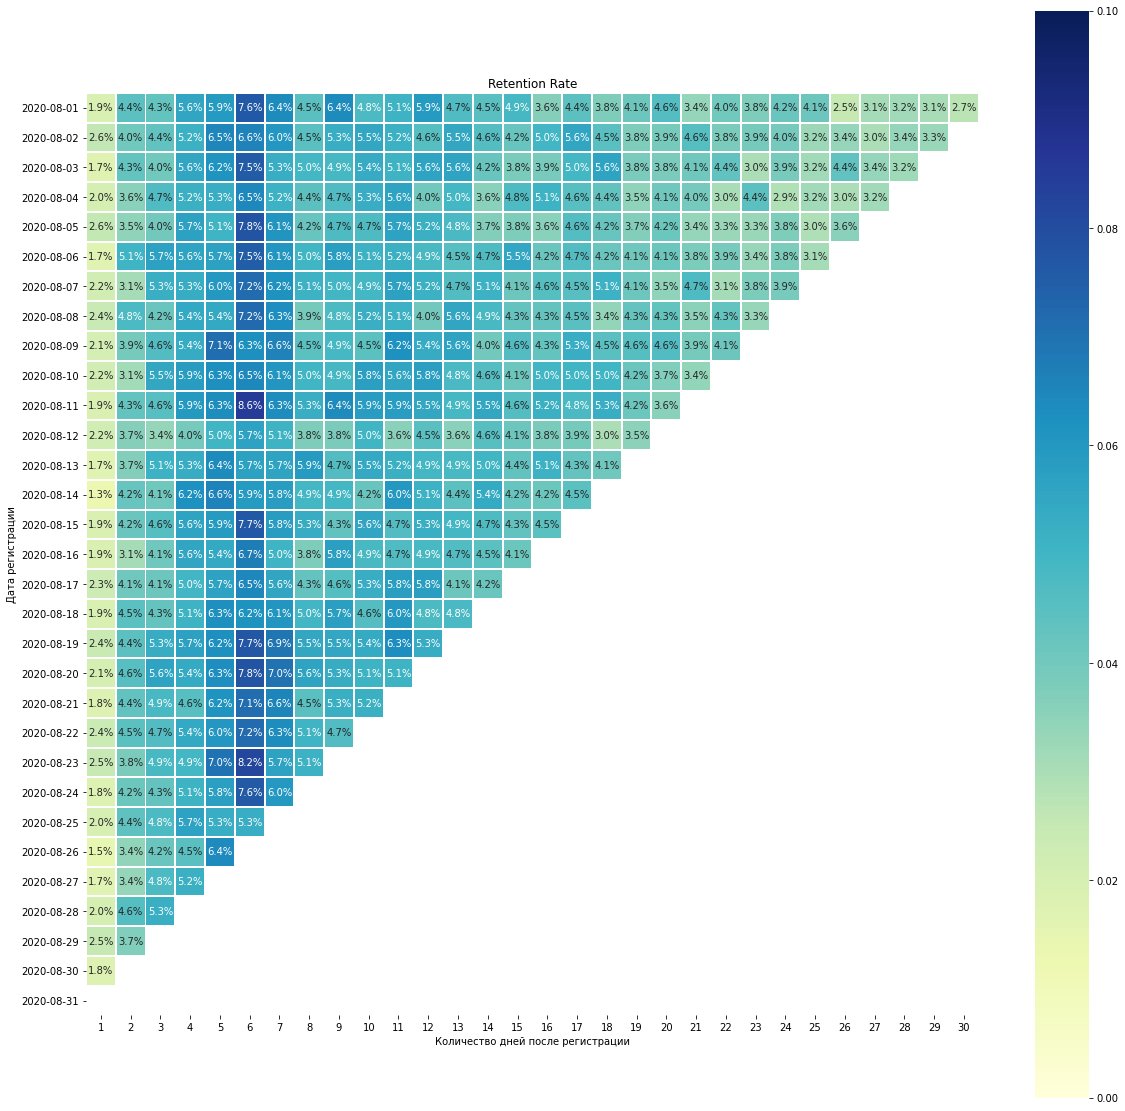

In [32]:
plt.figure(figsize=(20, 20))
sns.heatmap(result_grouped, vmin=0.0, vmax=0.1, cmap="YlGnBu", 
            fmt='.1%', annot=True, linewidths=1, linecolor='white', square=True)
plt.title('Retention Rate')
plt.ylabel('Дата регистрации')
plt.xlabel('Количество дней после регистрации');

Отдельно все этапы работают нормально. Напишем функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [33]:
def get_retention(reg_data, auth_data, start_date, end_date):
    """
    Вычисляет коэффициент удержания пользователей на основе данных о регистрации и авторизации.

    Параметры:
    reg_data (DataFrame): Данные о регистрации пользователей.
    auth_data (DataFrame): Данные о авторизации пользователей.
    start_date (datetime): Дата начала фильтрации.
    end_date (datetime): Дата окончания фильтрации.
    
    Шаги:
    Вычисление разницы между датой регистрации и датой захода пользователя в игру в днях.
    Фильтрация пользователей по необходимым датам.
    Вычисление размеров когорт и расчет retention.
    Построение графика.

    Возвращает:
    DataFrame: Коэффициент удержания пользователей по когортам.
    """
    
    
    start_date = start_date
    end_date = end_date
        
    
    full_data['period'] = ((full_data.auth_date - full_data.reg_date) / np.timedelta64(1, 'D')).astype(int)
    
    
    filtr_date = full_data.query('reg_date >= @start_date and auth_date <= @end_date')

    
    cohorts = filtr_date.groupby(['reg_date', 'period'], as_index=False).agg({'uid': 'nunique'})\
                        .pivot(index='reg_date', columns='period', values='uid')
    result_grouped = cohorts.div(cohorts[0], axis=0)
    
    
    result_grouped = result_grouped.drop(columns=[0])
    
    
    plt.figure(figsize=(20, 20))
    sns.heatmap(result_grouped, vmin=0.0, vmax=0.1, cmap="YlGnBu", 
                fmt='.1%', annot=True, linewidths=1, linecolor='white', square=True)
    plt.title('Retention Rate')
    plt.ylabel('Дата регистрации')
    plt.xlabel('Количество дней после регистрации')
    
    
    return result_grouped

period,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
reg_date,,,,,,,,,,,,,,,,,,,
2019-01-01,0.020583,0.037736,0.049743,0.044597,0.063465,0.082333,0.058319,0.054889,0.060034,0.060034,0.046312,0.056604,0.034305,0.048027,0.046312,0.056604,0.048027,0.039451,0.046312
2019-01-02,0.017153,0.049743,0.036021,0.049743,0.080617,0.054889,0.070326,0.030875,0.041166,0.042882,0.058319,0.054889,0.049743,0.044597,0.046312,0.027444,0.048027,0.049743,NaN
2019-01-03,0.017094,0.030769,0.044444,0.059829,0.063248,0.064957,0.058120,0.022222,0.049573,0.047863,0.068376,0.034188,0.046154,0.039316,0.049573,0.042735,0.044444,NaN,NaN
2019-01-04,0.027350,0.037607,0.042735,0.054701,0.054701,0.080342,0.052991,0.042735,0.052991,0.056410,0.064957,0.059829,0.041026,0.041026,0.056410,0.039316,NaN,NaN,NaN
2019-01-05,0.018771,0.040956,0.046075,0.049488,0.081911,0.071672,0.069966,0.059727,0.040956,0.047782,0.064846,0.051195,0.058020,0.052901,0.040956,NaN,NaN,NaN,NaN
2019-01-06,0.017007,0.037415,0.052721,0.047619,0.059524,0.056122,0.057823,0.052721,0.047619,0.051020,0.061224,0.049320,0.039116,0.049320,NaN,NaN,NaN,NaN,NaN
2019-01-07,0.017007,0.042517,0.040816,0.054422,0.073129,0.073129,0.066327,0.054422,0.054422,0.034014,0.068027,0.047619,0.052721,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-08,0.030560,0.040747,0.050934,0.057725,0.071307,0.071307,0.066214,0.057725,0.039049,0.049236,0.052632,0.050934,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-09,0.010169,0.027119,0.042373,0.052542,0.059322,0.064407,0.044068,0.057627,0.050847,0.044068,0.044068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


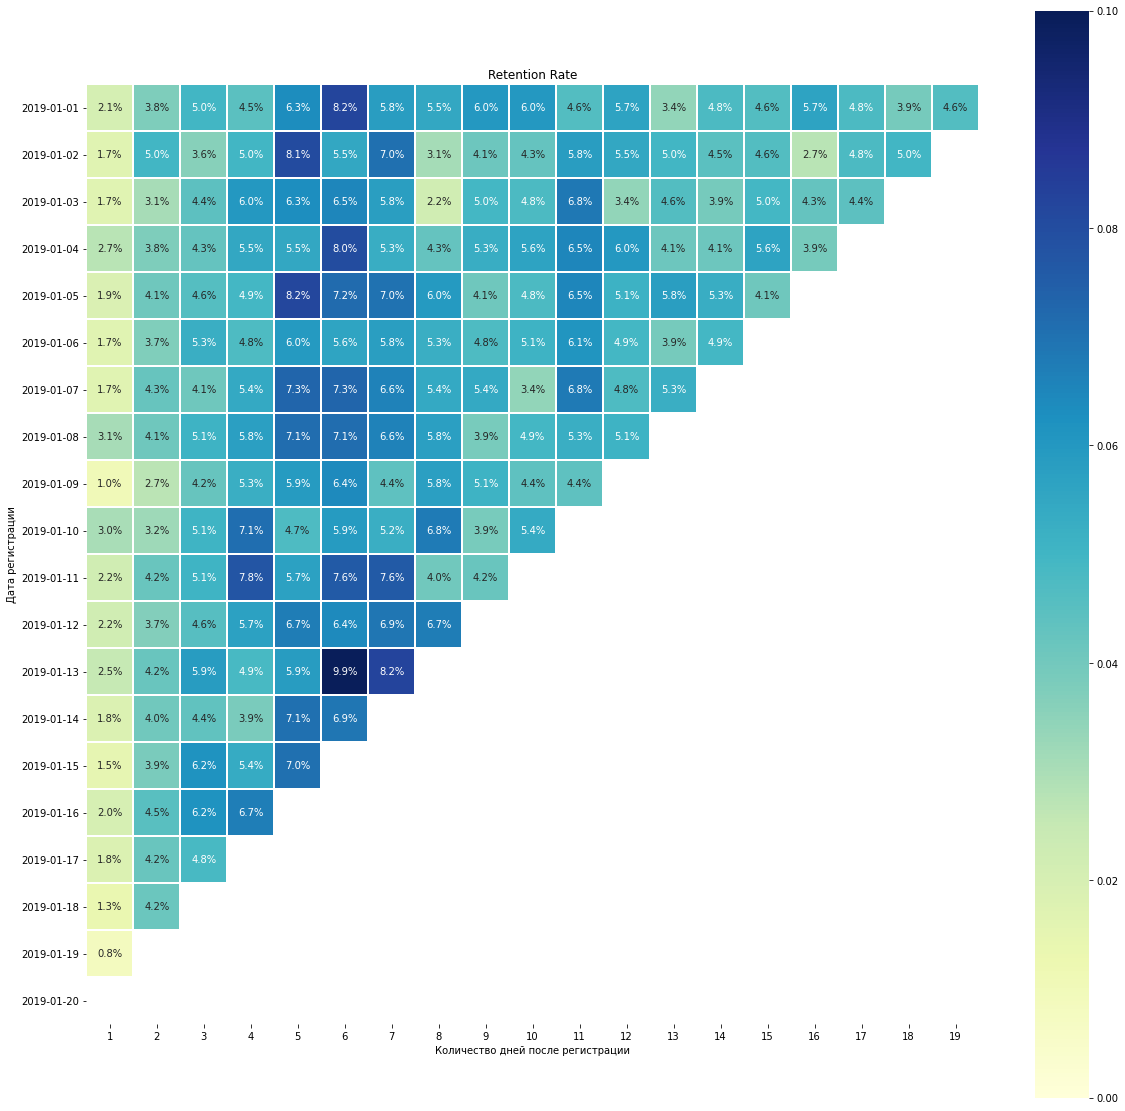

In [34]:
retention = get_retention(
    reg_data, auth_data, start_date=datetime.date(2019, 1, 1), end_date=datetime.date(2019, 1, 20))

retention

**Вывод**: На основе наших данных была написана функция для расчета Retention.

## Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Откроем файл с данными и выведем на экран первые 5 строчек датафрейма data_ab.

In [35]:
data_ab = pd.read_csv('Проект_1_Задание_2.csv', sep=';')

In [36]:
data_ab.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


Посмотрим количество строк и столбцов в датафрейме data_ab. А также какой тип данных в каждом столбце.

In [37]:
data_ab.shape

(404770, 3)

In [38]:
data_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


Проверим наличие пропусков в столбцах.

In [39]:
data_ab.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

Посмотрим на количество уникальных пользователей.

In [40]:
data_ab.user_id.nunique()

404770

В датафрейме data_ab все пользователи уникальны и не встречаются сразу в двух группах. 

### Основная часть

Посмотрим на количество пользователей, количество платящих пользователей, выручку, конверсию и ARPU в разрезе групп и сравним их.

#### Количество пользователей на группу

In [41]:
counts_users_a = data_ab.query('testgroup == "a"').user_id.nunique()
print('Количество уникальных пользователей контрольной группы:', counts_users_a)

Количество уникальных пользователей контрольной группы: 202103


In [42]:
counts_users_b = data_ab.query('testgroup == "b"').user_id.nunique()
print('Количество уникальных пользователей тестовой группы:', counts_users_b)

Количество уникальных пользователей тестовой группы: 202667


In [43]:
print('Разница между группами:', counts_users_b - counts_users_a, 'пользователей')

Разница между группами: 564 пользователей


In [44]:
round((counts_users_b - counts_users_a) / (counts_users_b + counts_users_a) * 100, 2)

0.14

Тестовая и контрольная группы почти одинаковы, разница меньше 1%.

#### Количество платящих пользователей в группах

In [45]:
count_paying_users_a = data_ab.query('testgroup == "a" and revenue > 0').user_id.nunique()
print('Количество уникальных платящих пользователей контрольной группы:', count_paying_users_a)

Количество уникальных платящих пользователей контрольной группы: 1928


In [46]:
count_paying_users_b = data_ab.query('testgroup == "b" and revenue > 0').user_id.nunique()
print('Количество уникальных платящих пользователей тестовой группы:', count_paying_users_b)

Количество уникальных платящих пользователей тестовой группы: 1805


In [47]:
print('Разница между группами:', count_paying_users_a - count_paying_users_b, 'платящих пользователя')

Разница между группами: 123 платящих пользователя


In [48]:
round((count_paying_users_a - count_paying_users_b) / (count_paying_users_a + count_paying_users_b) * 100, 2)

3.29

Тестовая и контрольная группы отличаются примерно на 3.5%.

#### Выручка

In [49]:
revenue_a = data_ab.query('testgroup == "a"').revenue.sum()
print('Выручка контрольной группы:', revenue_a)

Выручка контрольной группы: 5136189


In [50]:
revenue_b = data_ab.query('testgroup == "b"').revenue.sum()
print('Выручка тестовой группы:', revenue_b)

Выручка тестовой группы: 5421603


In [51]:
print('Разница в выручке между группами:', revenue_b - revenue_a)

Разница в выручке между группами: 285414


In [52]:
round((revenue_b - revenue_a) / (revenue_b + revenue_a) * 100, 2)

2.7

Выручка между тестовой и контрольной группами отличаются на 2.7%.

#### Конверсия

In [53]:
conversion_a = round((count_paying_users_a / counts_users_a) * 100, 2)
print('Конверсия в контрольной группе:', conversion_a)

Конверсия в контрольной группе: 0.95


In [54]:
conversion_b = round((count_paying_users_b / counts_users_b) * 100, 2)
print('Конверсия в тестовой группе:', conversion_b)

Конверсия в тестовой группе: 0.89


#### ARPU

In [55]:
arpu_a = round(revenue_a / counts_users_a, 2)
print('ARPU в контрольной группе:', arpu_a)

ARPU в контрольной группе: 25.41


In [56]:
arpu_b = round(revenue_b / counts_users_b, 2)
print('ARPU в тестовой группе:', arpu_b)

ARPU в тестовой группе: 26.75


проверим, что ARPU в тестовой группе выше на 5% чем в контрольной.

In [57]:
round(((arpu_b / arpu_a * 100) - 100), 2)

5.27

#### ARPPU

In [58]:
arppu_a = round(revenue_a / count_paying_users_a, 2)
print('ARPPU в контрольной группе:', arppu_a)

ARPPU в контрольной группе: 2664.0


In [59]:
arppu_b = round(revenue_b / count_paying_users_b, 2)
print('ARPPU в тестовой группе:', arppu_b)

ARPPU в тестовой группе: 3003.66


In [60]:
round(((arppu_b / arppu_a * 100) - 100), 2)

12.75

ARPPU в тестовой группе больше на 12.75% чем в контрольной.

Создадим два датафрейма, разделив данные на тестовую и контрольную группы.

In [61]:
group_a = data_ab.query('testgroup == "a"')

In [62]:
group_b = data_ab.query('testgroup == "b"')

Посмотрим на описательную статистику.

In [63]:
group_a['revenue'].describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [64]:
group_b['revenue'].describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

Средние значения в группах 25.41 и 26.75. Так как многие пользователи не совершали покупок, то медианное значение в двух группах равняется нулю.

Нарисуем boxplot.

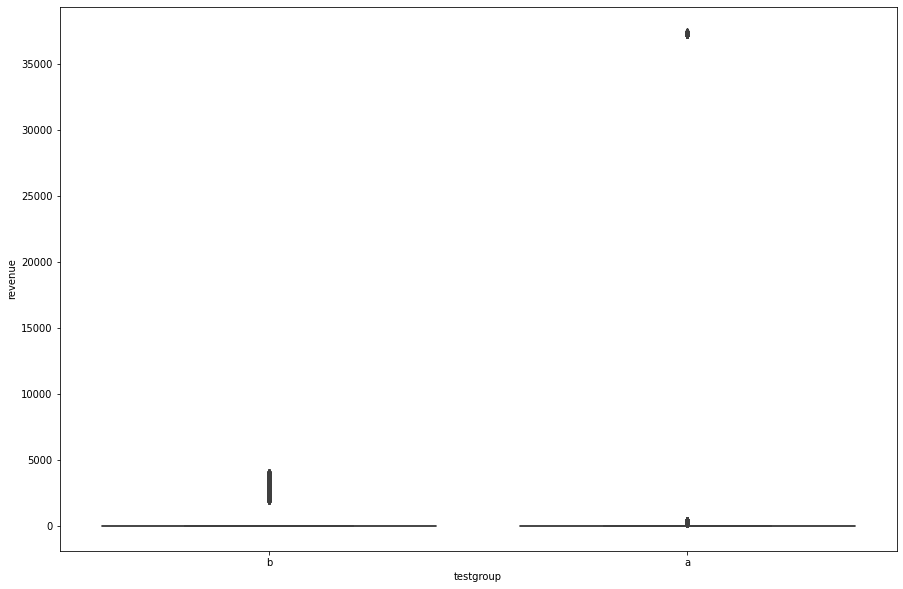

In [65]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=data_ab, x='testgroup', y='revenue');

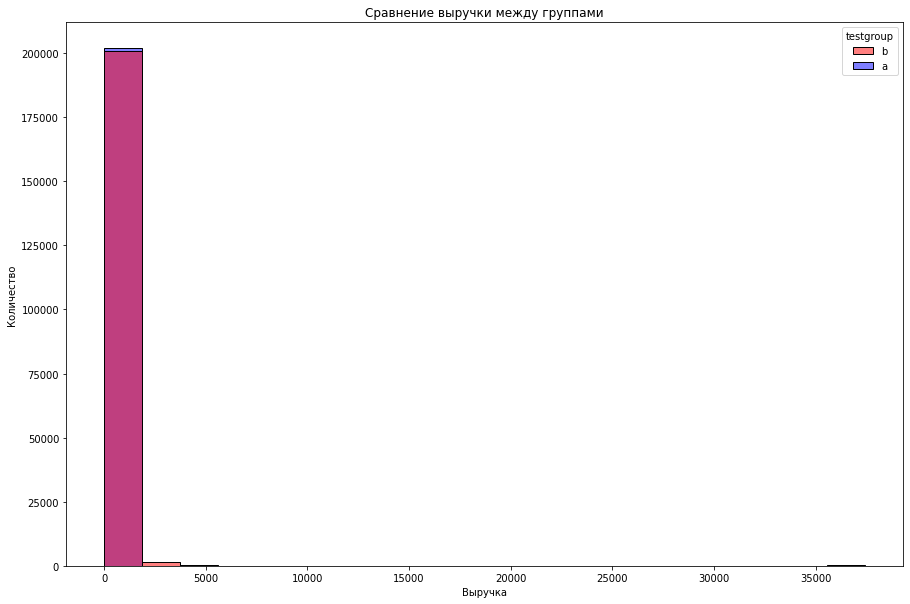

In [66]:
plt.figure(figsize=(15, 10))
groups = sns.histplot(data=data_ab, 
             x='revenue', 
             hue='testgroup', 
             palette=['r', 'b'],
             alpha=0.5,
             kde=False)
plt.title('Сравнение выручки между группами')
plt.xlabel('Выручка')
plt.ylabel('Количество');

Многие пользователи не совершали никаких покупок, но так как на данном этапе нас интересует выручка, то исключим тех пользователей, которые не совершали покупки(так как картина не совсем понятна), и снова посмотрим на описательную статистику.

In [67]:
group_a_paying_users = data_ab.query('testgroup == "a" and revenue > 0')

In [68]:
group_b_paying_users = data_ab.query('testgroup == "b" and revenue > 0')

In [69]:
group_a_paying_users['revenue'].describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [70]:
group_b_paying_users['revenue'].describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

Видим, что среднее теперь отличается прилично между группами, 2664 и 3004, также медианные значения очень сильно отличаются между группами. В контрольной группе среднее значение значительно выше медианы. Это указывает на влияние высоких выбросов, которые подтягивают среднее значение вверх. В группе B среднее и медианная значения близки друг к другу, что сигнализирует о более равномерном распределении выручки. 

Почему мы рассматриваем медиану?

Медианная выручка контрольной группы составляет 311, а тестовой 3022. Это означает, что 50% пользователей генерируют выручку ниже этого значения, а 50% — выше. Мы наблюдаем, что наличие нескольких высокоплатящих клиентов в контрольной группе может искажать среднее значение, но медианная выручка дает более точное представление о том, как выглядит типичная ситуация среди большинства пользователей.

Различие между средним и медианной помогает оценить целостность данных. Высокое стандартное отклонение и значительная разница между средним и медианой могут указывать на наличие выбросов и необходимость дальнейшего анализа.

Визуализация распределения выручки

Графики помогут наглядно представить данные. Для визуализации распределения выручки используем гистограмму и boxplot для понимания тенденции и разброса значений.

Нарисуем boxplot.

In [71]:
data_paying_users = data_ab.query('revenue != 0')

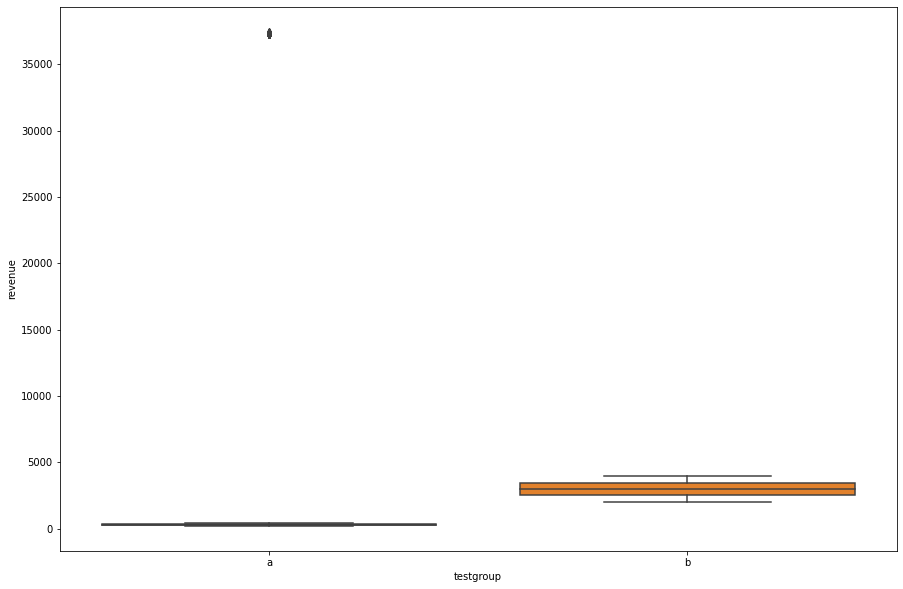

In [72]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=data_paying_users, x='testgroup', y='revenue');

Наблюдаем огромные выбросы в контрольной группе.

Сравним выручки между группами при помощи графика.

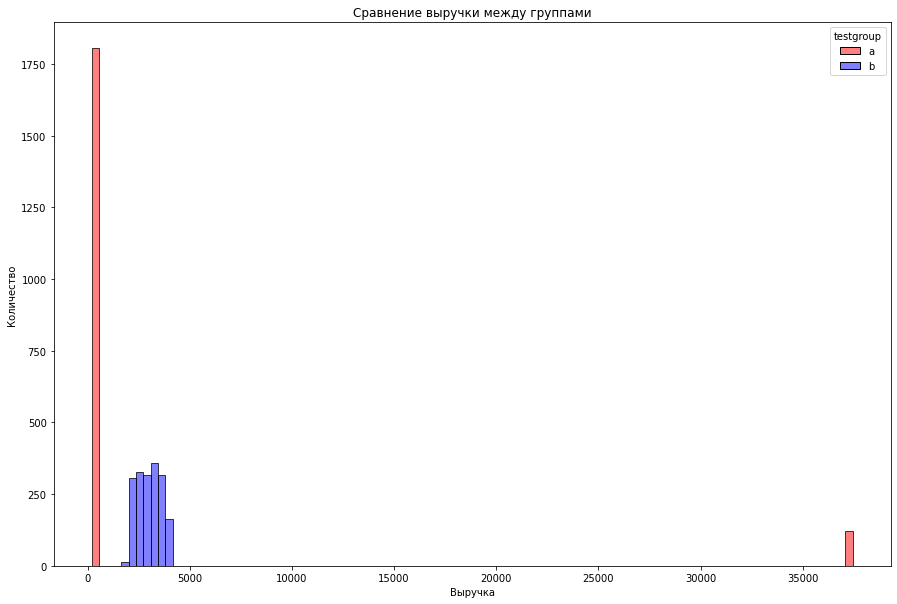

In [73]:
plt.figure(figsize=(15, 10))
groups = sns.histplot(data=data_paying_users, 
             x='revenue', 
             hue='testgroup', 
             palette=['r', 'b'],
             alpha=0.5,
             kde=False)
plt.title('Сравнение выручки между группами')
plt.xlabel('Выручка')
plt.ylabel('Количество');

Наблюдаем, что в контрольной группе большая часть данных находится около 300, при этом наблюдаются выбросы. В тестовой группе все данные находятся в промежутке от 2000 до 4000.

Такие выбросы могут указывать на сезонные изменения(праздники или специальные акции), маркетинговые усилия(хорошая реклама), оплата подписки. Возможно, эти выбросы никак не связаны с проведенным ab-тестом.

Посмотрим на количество пользователей, у которых revenue > 35000.

In [74]:
group_a_paying_users.query('revenue > 35000')

,user_id,revenue,testgroup
416,417,37324,a
4428,4429,37304,a
5777,5778,37315,a
8065,8066,37307,a
8743,8744,37334,a
...,...,...,...
360696,360697,37347,a
378668,378669,37297,a
389341,389342,37298,a
394580,394581,37302,a


Посчитаем процент от всех платящих пользователей контрольной группы.

In [75]:
group_a_paying_users.query('revenue > 35000').user_id.count() / group_a_paying_users.user_id.count() * 100

6.379668049792531

6.4% достаточно много. Эти данные мы не можем удалить, так как эти пользователи могут быть большими фанатами игры и тратить большие суммы на нее.

Но из-за этих выбросов мы не можем воспользоваться t-тестом.

Размер выборки нормальный, но распределение не нормальное, поэтому будем использовать bootstrap. Для этого пропишем функцию для работы с bootstrap.

In [76]:
def get_bootstrap(
    data_column_1,
    data_column_2,
    boot_it=1000,
    statistic=np.mean,
    bootstrap_conf_level=0.95
):
    """
    Выполняет бутстрэппинг для оценки разницы между двумя выборками.

    Параметры:
    data_column_1: Первая выборка данных.
    data_column_2: Вторая выборка данных.
    boot_it: Количество бутстрэп-подвыборок.
    statistic: Функция для вычисления интересующей статистики (по умолчанию - среднее).
    bootstrap_conf_level: Уровень значимости(по умолчанию 0.95).

    Возвращает:
    Словарь, с бутстрэп-данными, доверительным интервалом и p-значением.
    """
    
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title('Histogram of boot_data')
    plt.show()
       
    return {'boot_data': boot_data, 
            'ci': ci, 
            'p_value': p_value}

Проверим следующие метрики на статзначимые различия:
* ARPU
* ARRPU
* Конверсия
* Медианные значения выручки

Так как в контрольной группе у нас есть выбросы, то медианные значения сильно отличаются, при этом средние значения между группами у платящих пользователей отличаются не так сильно. Думаю, что стоит сравнить между собой ARRPU и медианные значения выручки, чтобы понять, как эти метрики соотносятся друг с другом и сделать выводы.

#### Формулировка и проверка гипотез

#### ARPU

Проверим есть ли различия между группами в средних значениях выручки, не исключая пользователей, которые не совершали покупки.

Сформулируем гипотезы:
* Нулевая гипотеза(H0): статистически значимых различий в средних значениях выручки между группами нет
* Альтернативная гипотеза(H1): статистически значимые различия в средних значениях выручки между группами есть

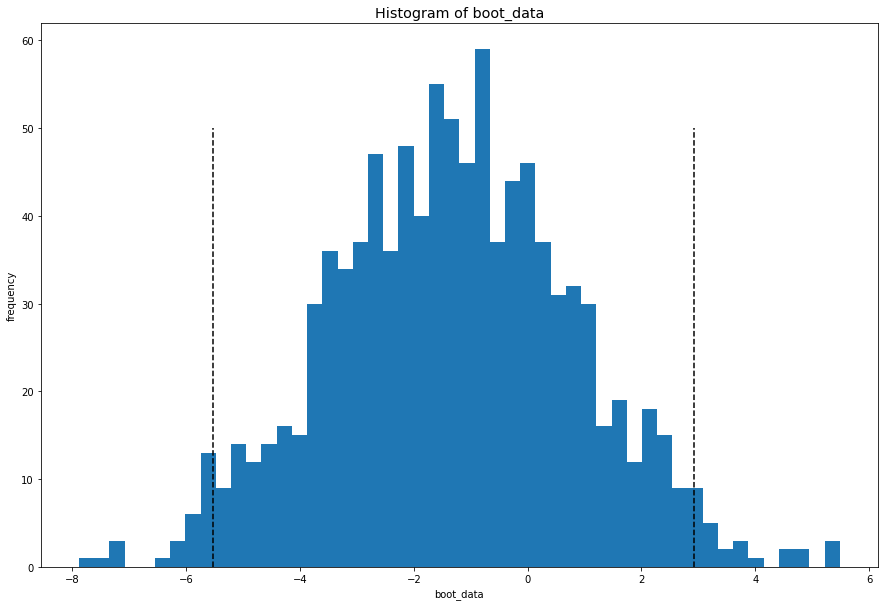

In [77]:
plt.figure(figsize=(15, 10))
booted_data_all_users = get_bootstrap(
    group_a.revenue,
    group_b.revenue,
    statistic=np.mean)

In [78]:
booted_data_all_users['p_value']

0.5424016999221312

p-value > 0.05, поэтому мы не можем отклонить нулевую гипотезу.

#### ARRPU

Сформулируем гипотезы:
* Нулевая гипотеза(H0): статистически значимых различий в средних значениях выручки между группами нет
* Альтернативная гипотеза(H1): статистически значимые различия в средних значениях выручки между группами есть

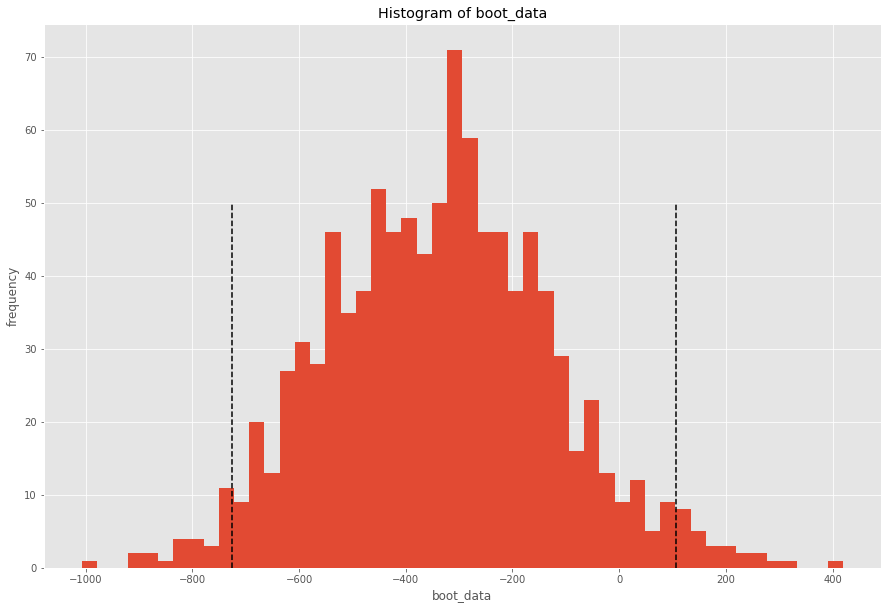

In [79]:
plt.figure(figsize=(15, 10))
booted_data_paying_users_mean = get_bootstrap(
    group_a_paying_users.revenue,
    group_b_paying_users.revenue,
    statistic=np.mean)

In [80]:
booted_data_paying_users_mean['p_value']

0.10893309976239157

p-value > 0.05, поэтому мы не можем отклонить нулевую гипотезу.

#### Конверсия

Посмотрим на конверсию. 

Проверим, есть ли различия в конверсии между группами.

Так как у нас две категориальные переменные (принадлежность к группе и наличие покупки), будем использовать хи-квадрат.

Сформулируем гипотезы:

* Нулевая гипотеза(H0): статистически значимых различий между группами нет
* Альтернативная гипотеза(H1): статистически значимые различия между группами есть

Создадим таблицу, в которой отобразим распределение значений в наборе данных, путем подсчета числа вхождений каждого значения, т.е. таблицу с разбивкой пользователей по группам и покупкам(или их отсутсвия).

In [81]:
data_ab['payers'] = data_ab['revenue'].apply(lambda x: 1 if x > 0 else 0)
conv_data_ab = data_ab.groupby('testgroup').agg({'user_id': 'count', 'payers': 'sum'})
conv_data_ab['user_id'] = conv_data_ab['user_id'] - conv_data_ab['payers']
conv_data_ab = conv_data_ab.rename(columns={'user_id': 'not_payers'})
conv_data_ab

,not_payers,payers
testgroup,,
a,200175,1928
b,200862,1805


Визуализируем данные при помощи тепловой карты.

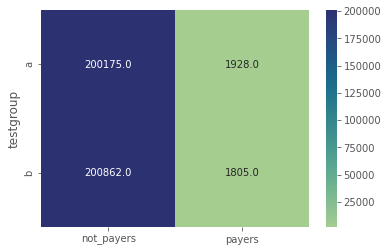

In [82]:
sns.heatmap(conv_data_ab, cmap="crest", annot=True, fmt=".1f");

Как и было написано ранее, количество пользователей в группах примерно одинаковое количество, количество платящих пользователей отличиется примерно на 3%.

alpha = 0.05 - критический уровень статистической значимости. Если p-value окажется меньше него - отклоняем гипотезу.

Выполним тест независимости хи-квадрат, чтобы определить, существует ли значительная связь между двумя категориальными переменными, при помощи функции chi2_contingency из библиотеки SciPy.

In [83]:
stat, p, dof, expected = chi2_contingency(conv_data_ab)

In [84]:
stat, p

(4.374729521260405, 0.03647561892312613)

Так как p-value меньше уровня значимости, то мы отклоняем нулевую гипотезу. Наборы акционных предложений для контрольной группы оказали влияние на желание пользователей совершать покупки.

Теперь проверим есть ли различия между группами в медианных значениях выручки, исключая пользователей, которые не совершали покупки. Используем медианные значения, так как в тестовой группе у нас есть выбросы.

#### Медианное значение

Рассмотрим медианные значения, потому что:

* Устойчивость к выбросам: Медиана не подвержена влиянию крайне высоких или низких значений, что делает ее более надежной метрикой для оценки типичной выручки пользователей.
  
* Отражение распределения: Медиана позволяет понять, где сосредоточена большая часть выручки, что может быть более информативным, чем среднее значение, которое может искажаться выбросами.

Так как у нас уже проведен статистический анализ ARRPU, то мы можем провести статистический анализ медианных значений, чтобы понять, как эти метрики соотносятся друг с другом и сделать выводы.

Сформулируем гипотезы:
* Нулевая гипотеза(H0): статистически значимых различий в медианных значениях выручки между группами нет
* Альтернативная гипотеза(H1): статистически значимые различия в медианных значениях выручки между группами есть

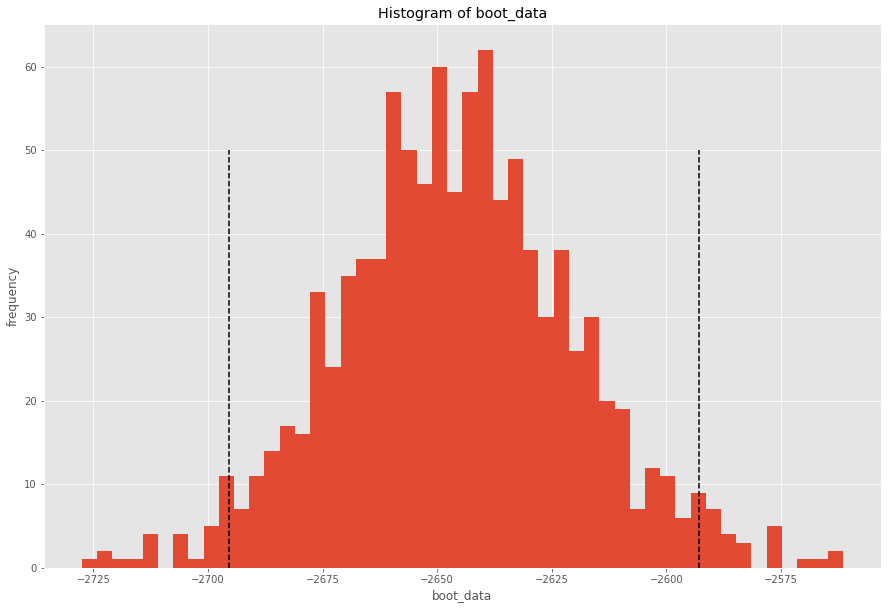

In [85]:
plt.figure(figsize=(15, 10))
booted_data_paying_users_median = get_bootstrap(
    group_a_paying_users.revenue,
    group_b_paying_users.revenue,
    statistic=np.median)

In [86]:
booted_data_paying_users_median['p_value']

0.0

p-value < 0.05, и 0 не входит в доверительный интервал, а это значит, что статистически значимые различия в медианных значениях выручки между группами есть.

**Вывод:** пользователи на группы разбиты примерно одинаково, количество платящих пользователей в группах отличается на 3,5% (в контрольной группе больше чем тестовой), выручка между тестовой и контрольной группами отличаются на 2.7% (в тестовой группе больше чем контрольной), ARPU в тестовой группе выше на 5% чем в контрольной, ARPPU в тестовой группе больше на 12.75% чем в контрольной.
В контрольной группе есть выбросы. Поэтому для проверки гипотезы использовали bootstrap, кроме конверсии, так как там две категориальные переменные (принадлежность к группе и наличие покупки) - использовали хи-квадрат.

Выводы по статанализу: 

* ARPU и ARRPU не продемонстрировали статистически значимых различий между группами, однако, конверсия показала, что определенные акционные предложения оказали влияние на повышение покупательской активности пользователей.

* При рассмотрении медианных значений выручки было обнаружено значимое различие, что подчеркивает важность медианы в контексте наличия выбросов.

* Эти результаты подчеркивают, что при планировании акционных предложений и оценке их эффективности важным аспектом является как средняя, так и медианная выручка, а также уровень конверсии.

Сложно дать однозначный ответ какие наборы акционных предложений лучше, так как у нас нет никакой информации про дорогие покупки в контрольной группе(выбросы). Возможно это был какой-то сезонный всплеск или событие, которое никак не связано с проведением ab-теста. А возможно, что в контрольную группу попали пользователи из определенного сегмента. Но то, что в одну группу попали пользователи с большими покупками, а во вторую нет, может говорить о том, что изначально пользователи неправильно были разделены на группы.

На основании этих данных можно рекомендовать провести ab-тест заново, уделить больше времени к подговке, более тщательному разделению пользователей на группы, дальнейшей проверке групп на корректность, более глубокий анализ и потенциальную корректировку стратегий, направленных на увеличение конверсии и выручки, а также дальнейшие эксперименты для более точной настройки акционных предложений.


## Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Приоритизация и классификация метрик:

Метрики роста:

1. DAU, WAU, MAU. Для начала нужно посчитать количество активных пользователей в период проведения тематического события. Как пользователи будут вести себя от начала до конца события(DAU, WAU, MAU). А также необходимо сравнить как вели себя пользователи всех прошедших событий по сравнению с последним (нами оцениваемым). С помощью этой метрики можно оценить на сколько пользователям было интересно данное событие. 

2. Новые пользователи. Разбить пользователей на сегменты, чтобы посмотреть количество новых, старых и ушедших пользователей. Если событие было интересно пользователям, то количество новых и старых пользователей будет расти, а ушедших будет небольшой процент.

Метрики продукта:

3. Retention Rate. Необходимо посмотреть на Retention, чтобы понять как событие повлияло на удержание пользователей. Стало ли их больше после проведения тематического события.

4. Время в игре. Сколько времени пользователь провел в игре, изменилось ли его времяпрепровождение с началом проведения тематического события и после окончания.

5. Уровни «отказа», откаты. Можно проверить, нет ли таких уровней, на которых отваливается большая часть пользователей.

Метрики вовлеченности:

6. Частота завершения уровней. Какое количество пользователей переходит на следующий уровень игры, сколько пользователей проходят все уровни за определенное время. 

7. Количество предметов и бонусов. Активность и интерес пользователей можно оценить с помощью количества предметов и бонусов, которые пользователь может получить во время проведения тематического события.

Метрики дохода:

8. Revenue. Если в игре на момент проведения тематического события есть платные услуги, то посмотреть как событие влияет на revenue.

При усложнении механики следует смотреть:

1. Какое количество пользователей возвращаются в игру. Тут есть риск, что вместо мотивации пользователей можно получить их раздраженность, которая приведет к потере пользователей.

2. Как часто пользователи откатываются назад, после какой попытки пройти уровень они продвигаются дальше или перестают играть.

3. Активность пользователей.

4. Время, которое пользователь проводит в игре.

Использование этих метрик поможет глубже понять зависимость между механиками событий и поведением пользователей. Это позволит не только оценить эффективность текущих событий, но и принимать более обоснованные решения о будущем игровом контенте.